In [22]:
# Imports
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
%matplotlib inline

### Synthetic data

In [12]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


## Make algo from paper

In [10]:
# Functions for segmentation. Last function calls all of the above. 

def find_window(dataframe, window_size=3):
    """dataframe must have feature topic_probs
    returns: cosine similarities for full transcript"""
    transcript_cosine_similarities = []  # np.zeros(shape=(len(dataframe)-window_size*2, 1))

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.topic_probs[p-window_size:p]
        w_r = dataframe.topic_probs[p:p+window_size]

        # add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, height=-0.995):
    window_cosines_neg = window_cosines*-1
    # Find index of minimas
    minimas, _ = find_peaks(window_cosines_neg, height=height)
    for position in minimas:
        print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (neg cos sim): {window_cosines[position]}")
    return minimas


def hl(p, cos_sims):
    max_val = cos_sims[p]
    for i in range(p-1, 0, -1):  # Change -1 to 0
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def hr(p, cos_sims):
    max_val = cos_sims[p]
    for i in range(p+1, len(cos_sims)):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def depth_scores(cos_sims, minimas):
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size):
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score}")
    return boundaries


def segmentation_main_call(dataframe, window_size=3):
    window_cosines = find_window(dataframe, window_size)
    min = find_minimas(window_cosines, window_size)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size)
    return bounds

In [11]:
segmentation_main_call(testing_df)

Candidate boundary at sent. 10, p:7, value (neg cos sim): 0.8373392976609495
Candidate boundary at sent. 20, p:17, value (neg cos sim): 0.7959564428737198
Candidate boundary at sent. 30, p:27, value (neg cos sim): 0.8112600722219895
Candidate boundary at sent. 40, p:37, value (neg cos sim): 0.6916631162814308
Boundary at sentence 20, p:17, depth score: 0.20375474445607944
Boundary at sentence 30, p:27, depth score: 0.18856613923039844
Boundary at sentence 40, p:37, depth score: 0.30822016495591265


[20, 30, 40]

In [36]:
def plot_cosine_scores(cosine_similarities_for_windows):
    plt.style.use(['science','no-latex'])
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.lineplot(cosine_similarities_for_windows, ax=axs[0])
    axs[0].set_xlabel("p")
    axs[0].set_ylabel("Cosine similarity")

    neg_cosines_of_windows= cosine_similarities_for_windows*-1
    sns.lineplot(neg_cosines_of_windows, ax=axs[1])
    axs[1].set_xlabel("p")
    axs[1].set_ylabel("Negative cosine similarity")

    fig.suptitle("Cosine Similarities Over Transcript Windows")
    plt.show()

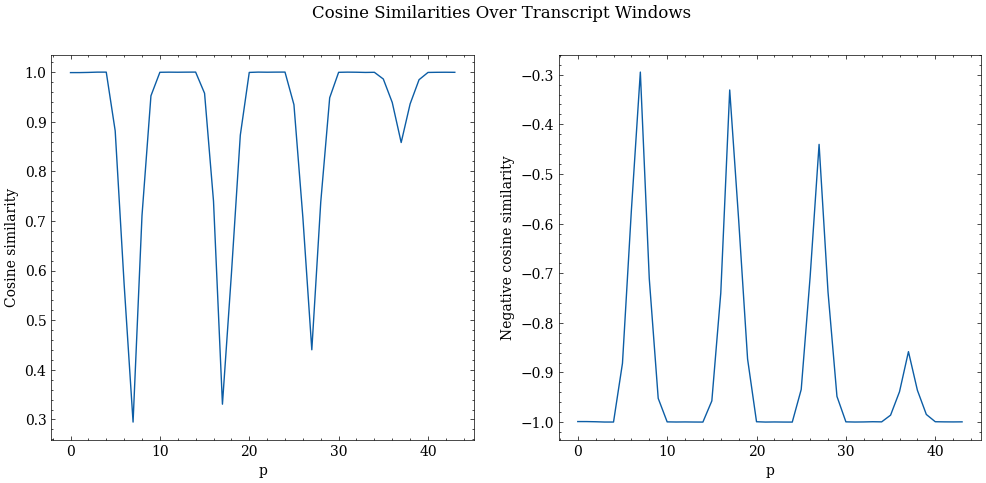

In [37]:
cos_sims = find_window(testing_df)
plot_cosine_scores(cos_sims)